# Spark - Dataset Analysis

## Task 1 - Citation posts analysis

You are given the `techcrunch_posts.csv` input file. It is a Comma Separated Values (CSV) file that contains blog posts that have been crawled from the Techcrunch blog community at 2010. Each row represents a blog post and has the following columns:

* `postId`: the ID of the post record in Techcrunch.
* `title`: the title of the blog post.
* `author`: the name of the blogger who authored the post.
* `authorId`: the ID of the blogger who authored the post.
* `comments`: the number of comments of the blog post.
* `content`: the full text of the blog post.
* `url`: the URL of the blog post.
* `date`: the publication date of the blog post.
* `inlinks`: the number of incoming links to this blogpost.

Dataset source: [https://www.kaggle.com/datasets/lakritidis/identifying-influential-bloggers-techcrunch](https://www.kaggle.com/datasets/lakritidis/identifying-influential-bloggers-techcrunch)


In [1]:
# Read the input file here
import os
import pyspark
from pyspark.sql import SQLContext, SparkSession
# Import functions as alias
from pyspark.sql import functions as F
import warnings
warnings.filterwarnings('ignore')

sc = SparkSession \
        .builder \
        .master('local[4]') \
        .appName("IHU_Spark_Standalone_TestApp") \
        .getOrCreate()

df = sc.read.option('delimiter', ',').option('header', 'true')\
    .csv("file://////home/hadoop/Documents/notebooks/Assignment2/BDCC_2025_Assignment2/techcrunch_posts.csv")

df.show(10)

25/07/28 14:29:26 WARN Utils: Your hostname, BDCC resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/07/28 14:29:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/28 14:29:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+--------------------+-----------------+--------+--------+--------------------+--------------------+----------+-------+
|postId|               title|           author|authorId|comments|             content|                 url|      date|inlinks|
+------+--------------------+-----------------+--------+--------+--------------------+--------------------+----------+-------+
|     1|We Just Tested Tw...|    Jason Kincaid|       1|      14|During his keynot...|http://techcrunch...|2010-04-01|      0|
|     2|Facebook To Launc...|    Jason Kincaid|       1|      30|Later this month ...|http://techcrunch...|2010-04-01|      0|
|     3|NYTimes Request C...|Michael Arrington|       2|      38|A NYTimes communi...|http://techcrunch...|2010-04-01|      4|
|     4|Google Shows How ...|  Erick Schonfeld|       3|      26|A lot of attentio...|http://techcrunch...|2010-04-01|     10|
|     5|The iPad: Apple&#...|       John Biggs|       4|      49|Something struck ...|http://www.crunch...|2010

### Task 1.1
Find the most active dates in number of submitted posts. Return a list with the publication dates ordered in reverse order of number of submitted posts.


In [4]:
# First we aggregate the dates by counting their appearances
df11 = df.groupBy("date").count()
# We sort the dates and their counts in descending order and print the result
df11.orderBy("count", ascending=False).show(5)

+----------+-----+
|      date|count|
+----------+-----+
|2009-09-14|   51|
|2009-09-15|   49|
|2009-09-09|   42|
|2009-10-13|   42|
|2009-06-24|   42|
+----------+-----+
only showing top 5 rows



### Task 1.2

Find the most cited authors. Return a list with the authors ordered in reverse order of citations.



In [8]:
from pyspark.sql.functions import sum, col

# First we aggregate the authors by counting their citations
df12 = df.groupBy("author").agg(sum(col('inlinks')).alias('citations'))
# We sort the authors and their total citations in descending order and print the result
df12.orderBy("citations", ascending=False).show(5)

+-----------------+---------+
|           author|citations|
+-----------------+---------+
|Michael Arrington|  86919.0|
|  Erick Schonfeld|  28430.0|
|       MG Siegler|  15208.0|
|    Jason Kincaid|  14409.0|
|     Duncan Riley|  11626.0|
+-----------------+---------+
only showing top 5 rows



### Task 1.3

Compute the average length (in words) of the blog posts per author. Return a list with the authors and the average post length (in words).

Sort the output in decreasing post length order. The top record shows the author that on average, publishes the longer posts.

In [10]:
# Write the code for task 1.3 here
from pyspark.sql.functions import avg, size, split, col, round
# We group authors by the average length of their posts
df13 = df.groupBy("author").agg(avg(size(split(col("content"), ' '))).alias("avg_word_count"))
# We round the lengths to 1 decimal point
df13_new = df13.withColumn('avg_word_count', round(df13.avg_word_count, 1))
# We sort the lengths and authors in descending order
df13_new.orderBy("avg_word_count", ascending=False).show(5)

+-----------------+--------------+
|           author|avg_word_count|
+-----------------+--------------+
|TechCrunch Europe|        2457.0|
|      Orli Yakuel|        1901.5|
|     Eric Clemons|        1562.0|
|      Brian Solis|        1540.0|
|         Susan Wu|        1453.0|
+-----------------+--------------+
only showing top 5 rows



### Task 1.4
Compute the h-index of the authors.

**$h$-index definition:** An author has an $h$-index equal to $h$, if $h$ of his/her $N$ blog posts have at least $h$ inlinks each and the other $(N – h)$ blog posts have $\leq h$ citations each. For instance, an $h$-index of 17 means that the blogger has authored at least 17 posts that have each been cited at least 17 times. If the bloggers's 18th most cited post was cited only 17 times, then the $h$-index will remain at 17. If the bloggers's 18th most cited publication was cited 18 or more times, the $h$-index would rise to 18.


In [53]:
# Write the code for task 1.4 here
from pyspark.sql import Window
from pyspark.sql.functions import col, row_number, desc, max as spark_max


# Groups rows by author and sorts the count of citations in descending order within each author partition
window = Window.partitionBy(author_col).orderBy(col(citation_col).desc())
# window function enables computations per author without splitting the df manually

# Add index to each partition(window), starting from 0. The highest citation for each author has value 0
df_with_idx = df.withColumn("idx", row_number().over(window) - 1)

# For each paper, check if citation > index
# if paper at idx = 2 has inlinks > 2, then it is valid for 2-index rank
df_valid = df_with_idx.withColumn("valid", col(citation_col) > col("idx"))

# Filter only valid rows (citation > idx)
df_filtered = df_valid.filter(col("valid"))

# H-index is the max idx + 1
h_index_df = df_filtered.groupBy(author_col).agg(
    spark_max("idx").alias("h_index_minus_1")
).withColumn("h_index", col("h_index_minus_1") + 1).drop("h_index_minus_1")


h_index_df.orderBy("h_index", ascending=False).show(10)

+-----------------+-------+
|           author|h_index|
+-----------------+-------+
|Michael Arrington|   4902|
|       Sarah Lacy|     89|
|           tcnikc|     81|
|    Jason Kincaid|     79|
|    Steve Gillmor|     70|
|       MG Siegler|     63|
|       Matt Burns|     57|
|     Mike Butcher|     54|
|    Robin Wauters|     53|
|    Greg Kumparak|     52|
+-----------------+-------+
only showing top 10 rows



## Task 2 - Car Prices analysis

You are given the `car_prices.csv` input file. It is a Comma Separated Values (CSV) file that provides information pertaining to the sales transactions of various vehicles. The dataset comprises 558837 rows and 16 columns and occupies around 85 MB.

Each row denotes a car sale. The columns represent:

1. `year`: The manufacturing year of the vehicle.
2. `make`: The brand or manufacturer of the vehicle.
3. `model`: The specific model of the vehicle.
4. `trim`: Additional designation for the vehicle model.
5. `body`: The body type of the vehicle (e.g., SUV, Sedan).
6. `transmission`: The type of transmission in the vehicle (e.g., automatic).
7. `vin`: Vehicle Identification Number, a unique code for each vehicle.
8. `state`: The state where the vehicle is registered.
9. `condition`: Condition of the vehicle, possibly rated on a scale.
10. `odometer`: The mileage or distance traveled by the vehicle.
11. `color`: Exterior color of the vehicle.
12. `interior`: Interior color of the vehicle.
13. `seller`: The entity selling the vehicle.
14. `mmr`: Manheim Market Report, possibly indicating the estimated market value of the vehicle.
15. `sellingprice`: The price at which the vehicle was sold.
16. `saledate`: The date and time when the vehicle was sold.

Dataset source: [https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data](https://www.kaggle.com/datasets/syedanwarafridi/vehicle-sales-data)

Similarly to almost all real-world datasets, this one has several data quality issues. One of these issues has to do with missing values. Therefore, there might be missing dates, brands, prices, colors, etc. Imputing missing values is out of the scope of this assignment. Consequently, in **all**  implementations, you **you must ignore all the rows that have missing values on columns 1, 2, 10, 11, 12, 15, and 16.** Fortunately, only a small portion of the records is going to be lost with this strategy.


In [90]:
# Read the input file here
df2 = sc.read.option('delimiter', ',').option('header', 'false')\
    .csv("file://////home/hadoop/Documents/notebooks/Assignment2/BDCC_2025_Assignment2/car_prices.csv")
# Dropping empy values in specified columns
cardf = df2.na.drop(subset=['_c0', '_c1', '_c9', '_c10', '_c11', '_c14', '_c15'])

cardf.show(10)

+----+---------+-------------------+--------------------+-----------+---------+-----------------+---+---+-----+-----+-----+--------------------+-----+-----+--------------------+
| _c0|      _c1|                _c2|                 _c3|        _c4|      _c5|              _c6|_c7|_c8|  _c9| _c10| _c11|                _c12| _c13| _c14|                _c15|
+----+---------+-------------------+--------------------+-----------+---------+-----------------+---+---+-----+-----+-----+--------------------+-----+-----+--------------------+
|2015|      Kia|            Sorento|                  LX|        SUV|automatic|5xyktca69fg566472| ca|  5|16639|white|black|kia motors americ...|20500|21500|Tue Dec 16 2014 1...|
|2015|      Kia|            Sorento|                  LX|        SUV|automatic|5xyktca69fg561319| ca|  5| 9393|white|beige|kia motors americ...|20800|21500|Tue Dec 16 2014 1...|
|2014|      BMW|           3 Series|          328i SULEV|      Sedan|automatic|wba3c1c51ek116351| ca| 45| 1331

### Task 2.1: Compute Yearly Statistics

In this task we are interested in computing yearly statistics about car sales. In particular, you will write a MapReduce task that computes the:

* number of vehicles per year,
* total value of the sold cars per year,
* average distance travelled by the sold cars per year and
* average age of the sold cars per year.


In [99]:
# Write the code for task 2.1 here

from pyspark.sql.functions import avg, count, col, sum, year, substring, to_timestamp

# First column = manufacturing year, last column = sale date
# We change last column to timestamp and then extract the year
cardf = cardf.withColumn("year", year(to_timestamp(substring("_c15", 5, 100), "MMM dd yyyy HH:mm:ss 'GMT'Z (z)")))
# Changing manuf. year from string to integer
cardf = cardf.withColumn("_c0", col("_c0").cast("integer"))
# Subtracting manufacturing year from sale year to determine age of each car
cardf = cardf.withColumn("year_diff", col("year") - col("_c0"))
# changing distance travelled column from string to integer
cardf = cardf.withColumn("_c9", col("_c9").cast("integer"))
# dropping null values
cardf = cardf.na.drop()

# aggregating results by the year of sale we extracted previously
df21 = cardf.groupBy("year").agg( count("*").alias("count"),
                                sum('_c14').alias("total_value"),
                                avg('_c9').alias("avg_dst"),
                                avg('year_diff').alias("avg_age")
                             )

df21.orderBy("year").show()

+----+------+-------------+-----------------+-----------------+
|year| count|  total_value|          avg_dst|          avg_age|
+----+------+-------------+-----------------+-----------------+
|2014| 36763| 4.67477709E8|71508.12972281914|4.376628675570546|
|2015|435562|5.998893399E9| 66296.0547820976|4.739424008522323|
+----+------+-------------+-----------------+-----------------+



### Task 2.2: Compute Yearly Statistics per Brand

In this task we are interested in the performance of the car sales **per brand, in a yearly fashion**. In fact, the task will compute the same statistics as those of Task 1, but also groupped by brand. More specifically, we are interested in computing the:

* number of vehicles per year, per brand,
* total value of the sold cars per year, per brand,
* average distance travelled by the sold cars per year, per brand and
* average age of the sold cars per year per brand.

Sort the output by brand, then by year.

Example output:

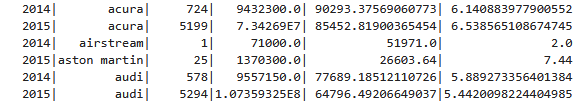


In [102]:
# Write the code for task 2.2 here

# aggregating results by the year of sale we extracted previously and by the car brand column
df22 = cardf.groupBy("year", "_c1").agg( count("*").alias("count"),
                                sum('_c14').alias("total_value"),
                                avg('_c9').alias("avg_dst"),
                                avg('year_diff').alias("avg_age")
                             )
# sorting by brand alphabetically
df22.orderBy("_c1", ascending=True).show()

+----+------------+-----+------------+------------------+-----------------+
|year|         _c1|count| total_value|           avg_dst|          avg_age|
+----+------------+-----+------------+------------------+-----------------+
|2015|       Acura| 4042| 5.2376125E7| 94399.05764473033|7.165017318159327|
|2014|       Acura|  461|   6634700.0| 81491.62689804772|5.357917570498915|
|2015|Aston Martin|   24|   1332000.0|23966.833333333332|7.416666666666667|
|2014|        Audi|  406|   7775700.0| 68410.91379310345| 5.04679802955665|
|2015|        Audi| 4396| 8.8313125E7|65142.901501364875|5.537989080982712|
|2015|         BMW|15969|3.40380823E8| 64183.30891101509|5.552445362890601|
|2014|         BMW| 1540| 3.2386555E7| 64026.82467532468|4.837012987012987|
|2015|     Bentley|   88|   6511950.0|37884.568181818184|7.045454545454546|
|2014|     Bentley|   17|   1122950.0|50915.529411764706|6.764705882352941|
|2014|       Buick|  334|   2901425.0| 86385.24251497006|6.931137724550898|
|2015|      

### Task 2.3: Large-scale analytics: Feature Exploration

In this task we will perform a part of what is called feature exploration. Feature exploration focuses on quantifying the impact of a particular feature on the target variable. While such analyses typically include all features, in this example we are only interested in finding out how the (exterior) color of a car affects its sales. More specifically, we need to compute:

* number of vehicles per (exterior) color, and
* the total value of the sold cars per color.

Sort the output in reverse number of sales.

Example output:

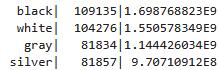


In [104]:
# Write the code for task 2.3 here

# aggregating results by the color column
df23 = cardf.groupBy("_c10").agg( count("*").alias("count"),
                                sum('_c14').alias("total_value")
                             )
# sorting by number of sales descending
df23.orderBy("count", ascending=False).show()

+---------+-----+-------------+
|     _c10|count|  total_value|
+---------+-----+-------------+
|    black|93244|1.442866834E9|
|    white|89233|1.326318247E9|
|   silver|71251| 8.44105904E8|
|     gray|70640| 9.85882549E8|
|     blue|43060| 4.97335254E8|
|      red|37336| 4.81549366E8|
|        —|22068| 3.93348864E8|
|     gold| 9563|  8.2450307E7|
|    green| 9234|  8.1264961E7|
| burgundy| 7605|  9.2155066E7|
|    beige| 7444|  7.0893993E7|
|    brown| 5621|  8.7304137E7|
|   orange| 1763|  2.3098988E7|
|   purple| 1270|  1.5593103E7|
|off-white| 1244|  1.9126002E7|
|   yellow| 1079|   1.379158E7|
| charcoal|  429|    6973851.0|
|turquoise|  190|    1675102.0|
|     pink|   39|     484150.0|
|     lime|   12|     152850.0|
+---------+-----+-------------+



### Task 2.4: Exploratory Analysis

In this task we will perform a part of what is called exploratory analysis. This process applies unsupervised techniques to a data collection with the aim of discovering potentially useful information. In this example we are interested in finding out the combination of exterior and interior colors that sells most. More specifically, we need to compute:

* the number of vehicles per pair of exterior/interior color.

Sort the output in reverse number of sales.

Example output:

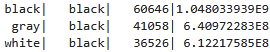

In [105]:
# Write the code for task 2.4 here

# aggregating results by the color column and interior column
df24 = cardf.groupBy("_c10", "_c11").agg( count("*").alias("count"),
                                sum('_c14').alias("total_value")
                             )
# sorting by number of sales descending
df24.orderBy("count", ascending=False).show()

+------+-----+-----+------------+
|  _c10| _c11|count| total_value|
+------+-----+-----+------------+
| black|black|52071|8.89493575E8|
|  gray|black|35497|5.49465276E8|
|silver|black|34788|4.73367382E8|
| white|black|31681|5.25649421E8|
|silver| gray|30172|2.96175291E8|
| white| gray|29900| 3.7716941E8|
|  gray| gray|26178|3.04428046E8|
| black| gray|22443|2.62677727E8|
|  blue| gray|17126|1.62632283E8|
|   red|black|16487|2.40963558E8|
|  blue|black|15935| 2.1237056E8|
| white|beige|13096|1.96860904E8|
|   red| gray|10963|1.16273655E8|
|     —|black|10850|1.98561461E8|
| white|  tan| 9553|1.34917825E8|
| black|beige| 8174|1.19685624E8|
| black|  tan| 6175| 8.6949929E7|
|     —| gray| 6022| 9.5316176E7|
|   red|beige| 4882| 6.2724225E7|
|  blue|beige| 4537| 5.7452082E7|
+------+-----+-----+------------+
only showing top 20 rows

